In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import meteva.base as meb
import meteva.method as mem
import meteva.product as mpd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import time
import pandas as pd
import matplotlib as mpl
import os

任务设定：读取最新的温度预报，按时效绘制TS变化

In [2]:
ip,port = meb.read_gds_ip_port(r"H:\test_data\input\meb\ip_port.txt")
now = datetime.datetime.now()
now = datetime.datetime(now.year,now.month,now.day,now.hour,0)
today = datetime.datetime(now.year,now.month,now.day,8,0)

In [3]:
station_alt = meb.read_station(meb.station_国家站)
station = station_alt.copy()
station["data0"] = 999999

In [4]:
dir_gds = r"GRAPES_GFS\TMP\2M_ABOVE_GROUND"
path_gds = r"GRAPES_GFS\TMP\2M_ABOVE_GROUND\YYMMDDHH.TTT"
gds_file_list = meb.tool.path_tools.get_gds_file_list_in_one_dir(ip,port,dir_gds)
dir_ob = r"O:\data\sta\SURFACE\QC_BY_FSOL\TMP_ALL_STATION\YYYYMMDD\YYYYMMDDHH0000.000"
hour_list = [8,12]
max_dd = 5
me = []
for dh in range(3,73,3):
    ob_list = []
    fo_list = []
    for dd in range(max_dd):
        ob_day = today - datetime.timedelta(days = dd)
        for hour in hour_list:
            fo_time =  datetime.datetime(ob_day.year,ob_day.month,ob_day.day,hour,0)
            ob_time = fo_time + datetime.timedelta(hours = dh)
            path_ob = meb.tool.path_tools.get_path(dir_ob,ob_time,0)       
            path_fo = meb.tool.path_tools.get_path(path_gds,fo_time,dh)
            dir1,filename = os.path.split(path_fo)
            if filename in gds_file_list: 
                if os.path.exists(path_ob):
                    #判断观测和预报文件存在                
                    grd = meb.read_griddata_from_gds(ip,port,path_fo)
                    if grd is not None:
                        sta_fo = meb.interp_gs_linear(grd,station)
                        #考虑到由于网格未覆盖所有station等原因，sta_fo可能和station长度不一致
                        #将预报sta_fo作为sta_ob的站点表,保证sta_ob和sta_fo站表完全一致
                        sta_ob = meb.read_stadata_from_gdsfile(path_ob,station = sta_fo)
                        value_ob0 = sta_ob.iloc[:,-1].values
                        value_fo0 = sta_fo.iloc[:,-1].values
                        value_ob = value_ob0[value_ob0 < 100]
                        value_fo = value_fo0[value_ob0 < 100]
                        ob_list.extend(value_ob.tolist())
                        fo_list.extend(value_fo.tolist())
    obs = np.array(ob_list)
    fos = np.array(fo_list)
    me1 = mem.me(obs,fos)
    me.append(me1)    

Text(0.5, 1.0, 'GRAPES温度预报误差')

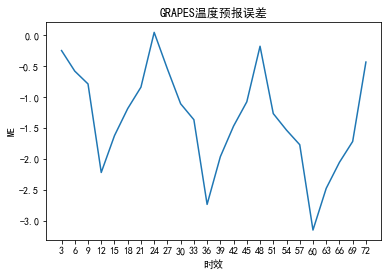

In [5]:
plt.plot(me)
plt.xlabel("时效")
x = np.arange(24)
xt = np.arange(3,73,3)
plt.xticks(x,xt)
plt.ylabel("ME")
plt.title("GRAPES温度预报误差")